<a href="https://colab.research.google.com/github/toussaintma/neuralnetworksfromzerotohero/blob/main/walkthrough_makemore_wavenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
# data and code at https://github.com/karpathy/makemore
# course at https://www.youtube.com/watch?v=PaCmpygFfXo&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&index=2&t=11s
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
# Building makemore Part 5: Wavenet

--2023-07-17 14:10:03--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt.1’

names.txt.1         100%[===================>] 222.80K  --.-KB/s    in 0.009s  

2023-07-17 14:10:04 (23.3 MB/s) - ‘names.txt.1’ saved [228145/228145]



In [26]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [27]:
df_words = pd.read_csv('names.txt', header=None, names=['name'])
words = df_words['name'].values.tolist()
df_words.shape

(32033, 1)

In [28]:
chars = sorted(list(set("".join(words))))
stoi = {c : i + 1 for i, c in enumerate(chars)}
stoi['.'] = 0
itos = {i + 1: chars[i] for i in range(len(chars))}
itos[0] = '.'

In [29]:
block_size = 3

In [30]:
def build_dataset(word):
  X = []
  Y = []
  for w in words[:]:
    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), ' --> ', itos[ix])
      context = context[1:] + [ix]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  return X, Y

import random
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

In [168]:
n_embd = 10
n_hidden = 200
vocab_size = 27
lossi = []
max_steps = 20000
batch_size = 32

model = nn.Sequential(
    nn.Embedding(vocab_size, n_embd), nn.Flatten(),
    nn.Linear(n_embd * block_size, n_hidden, bias=False), nn.BatchNorm1d(n_hidden), nn.Tanh(),
    nn.Linear(n_hidden, vocab_size),
)

with torch.no_grad():
  model[5].weight *= 0.01

parameters = [p for p in model.parameters()]

print(sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad = True

12097


In [169]:
model.train()
for i in range(max_steps):
  # mini batch
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix]


  # Forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb)

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 15000 else 0.01

  for p in parameters:
    p.data += -lr * p.grad

  # stats
  if (i % 1000 == 0):
    print(F'step:{i:7d}/{max_steps:7d} loss:{loss.item():.4f}')
  lossi.append(loss.log10().item())

step:      0/  20000 loss:3.2974
step:   1000/  20000 loss:2.3854
step:   2000/  20000 loss:2.6493
step:   3000/  20000 loss:2.5085
step:   4000/  20000 loss:2.5850
step:   5000/  20000 loss:2.4048
step:   6000/  20000 loss:2.0108
step:   7000/  20000 loss:2.2081
step:   8000/  20000 loss:2.5118
step:   9000/  20000 loss:2.1657
step:  10000/  20000 loss:2.3399
step:  11000/  20000 loss:2.0770
step:  12000/  20000 loss:2.3482
step:  13000/  20000 loss:2.2974
step:  14000/  20000 loss:2.2947
step:  15000/  20000 loss:1.9002
step:  16000/  20000 loss:2.2933
step:  17000/  20000 loss:2.2573
step:  18000/  20000 loss:1.9675
step:  19000/  20000 loss:2.1380


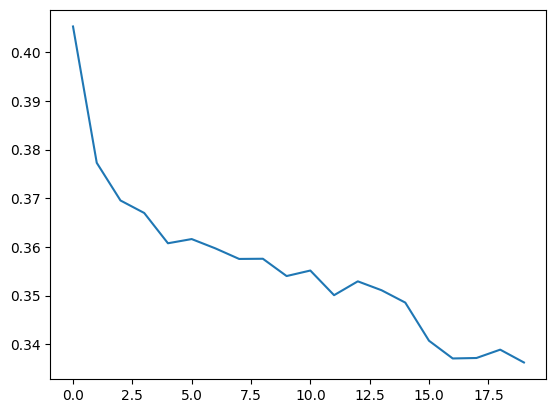

In [170]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [171]:
model.eval()

Sequential(
  (0): Embedding(27, 10)
  (1): Flatten(start_dim=1, end_dim=-1)
  (2): Linear(in_features=30, out_features=200, bias=False)
  (3): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): Tanh()
  (5): Linear(in_features=200, out_features=27, bias=True)
)

In [172]:
@torch.no_grad()
def split_loss(split):
  x,y = {
      'train': (Xtr, Ytr),
      'val': (Xdev, Ydev),
      'test': (Xte, Yte),
  }[split]

  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.1565449237823486
val 2.1565449237823486


In [173]:
def sample():
  output = []
  context = [0] * block_size
  sample = 0

  while True:
    logits = model(torch.tensor([context])) # 1, 3, 10
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, 1).item()
    context = context[1:] + [ix]
    output.append(ix)
    if ix == 0:
      break
  return output

In [174]:
for j in range(10):
  print(''.join([itos[i] for i in sample()]))

tean.
bana.
jamarier.
aisabpus.
shyn.
blanylei.
issleel.
brometi.
tavieaghawyah.
terron.
